1. Pulizia tabella con scelta dei dati numerici e utilizzo dei nuovi dati, isolare lo stato ILLINOIS
1. qualche plot sulle features nello stato di ILLINOIS   
2. normalizzazione dei dati
3. DBSCAN
4. ricerca degli hyperparametri
5. valutazione risultati e confronto tra i due cluster prodotti

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv("../../data/cluster.csv",skipinitialspace=True, sep=',',parse_dates=[0])
def inconsistence_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Rimuove le righe che presentano inconsistenze.
    """
    
    mask1 = df.incident_characteristics1 == 'Shot - Dead (murder, accidental, suicide)'
    mask2 = df.n_killed == 0
    final_mask = mask1 & mask2
    df = df[~final_mask]

    mask1 = df.incident_characteristics1 == 'Shot - Wounded/Injured'
    mask2 = df.n_injured == 0
    final_mask = mask1 & mask2
    df = df[~final_mask]
    
    return df

df=inconsistence_cleaning(df)
df=df[(df["state"]== "Illinois") & (df["n_participants"]>0)]
selected_columns = ['latitude', 'longitude','new_date', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', "avg_age_participants",
                'n_males', 'n_females', 'n_killed', 'n_arrested', 'n_unharmed', 'n_injured', 'n_participants', 'povertyPercentage']
#generi una nuova colonna che converte il date time in timestamp(formato giorni), così da poter essere utilizzato nel clustering
df["new_date"]=pd.to_datetime(df['date']).astype('int64')/ ((10**9)* 3600*24)
#n_participants == 0 conta come missing value dato che dovrebbe stare al denominatore
#drop delle entry con valori null e delle colonne non utili o non numeriche
data=df[selected_columns].dropna()
#posso droppare su tutte le features perchè new_date non ha missing value e tutte le altre features servono almeno 
#in una delle generazioni delle nuove features


In [109]:
df["party"].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11832 entries, 16 to 183143
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       11832 non-null  datetime64[ns]
 1   state                      11832 non-null  object        
 2   city_or_county             11832 non-null  object        
 3   address                    11498 non-null  object        
 4   latitude                   11832 non-null  float64       
 5   longitude                  11832 non-null  float64       
 6   congressional_district     11692 non-null  float64       
 7   state_house_district       11691 non-null  float64       
 8   state_senate_district      11692 non-null  float64       
 9   participant_age1           10539 non-null  float64       
 10  participant_age_group1     11088 non-null  object        
 11  participant_gender1        11463 non-null  object        
 12  mi

#### plot delle nuove features


<Axes: >

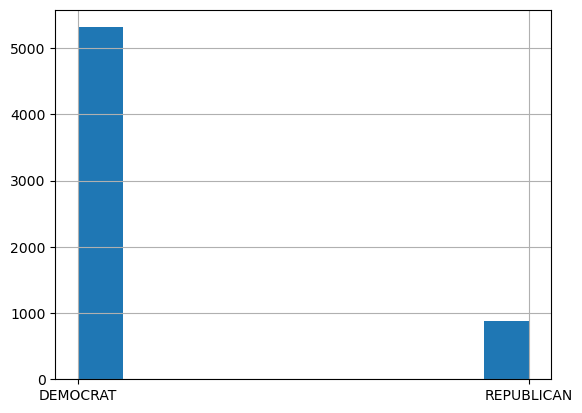

In [110]:
#plottarre la distribuzione degli incidenti in base al partito vincente nello stato di ILLINOIS
df["party"].hist()

In [111]:
df["povertyPercentage"].value_counts()

10.9    3628
10.4    3069
11.3    2487
12.2    2178
9.2      470
Name: povertyPercentage, dtype: int64

#### Dalla distribuzione del numero d'incidenti rispetto la povertà dello stato, non sembra esserci correlazione

                  winner_dominance     count
winner_dominance          1.000000  0.322157
count                     0.322157  1.000000


Text(0, 0.5, 'number of incident')

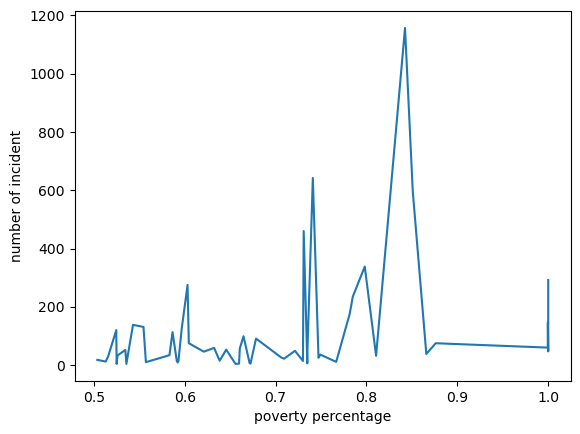

In [112]:
#plottare ad esempio la distribuzione di winnerdominance rispetto al numero di incidenti avvenuti
#la winner dominance è relativa ad un distretto in uno specifico anno, la distribuzione va fatta rispettando le specifiche
df["winner_dominance"]= df["candidatevotes"]/df["totalvotes"]
#non basta quindi contare il numero di incidenti con la stessa dominance perchè nello stesso gruppo vanno quelli con
#stessa stessa dominace, distretto e anno
temp=df[["congressional_district","winner_dominance","date"]].dropna()
temp["year"]=temp["date"].dt.year
temp=temp.drop(columns= ["date"])
temp["count"]=0
temp=temp.groupby(["congressional_district", "year","winner_dominance"],as_index=False)["count"].count()
#corerlazione tra winner dominance e count ?
print(temp[["winner_dominance","count"]].corr())
temp=temp[["winner_dominance","count"]]
temp.sort_values(by=["winner_dominance"],inplace=True)
fig, ax = plt.subplots()
ax.plot(temp["winner_dominance"],temp["count"])
ax.set_xlabel("poverty percentage")
ax.set_ylabel("number of incident")


#### non sembra esserci correlazione tra basso consenso dei voti del partito vincente in un distretto ed un aumento nel numero di incidenti nei diversi congressi ed anni

In [113]:
#definizione nuovi dati
data['n_participants_child_ratio'] = data['n_participants_child'] / data['n_participants']
data['n_participants_teen_ratio'] = data['n_participants_teen'] / data['n_participants']
data['n_participants_adult_ratio'] = data['n_participants_adult'] / data['n_participants']

data['n_males_ratio'] = data['n_males']/data['n_participants']
data['n_females_ratio'] = data['n_females']/data['n_participants']

data['n_arrested_ratio'] = data['n_arrested']/data['n_participants']
data['n_unharmed_ratio'] = data['n_unharmed']/data['n_participants']
data['n_injured_ratio'] = data['n_injured']/data['n_participants']
data['n_killed_ratio'] = data['n_killed']/data['n_participants']

data['poverty_ratio'] = data['povertyPercentage']/100

data['incident_severity'] = (data['n_killed_ratio'] + data['n_injured_ratio'])
#non c'è bisogno di definire quì la winner dominance in quanto non verrà usata nel clustering
#dalla matrice di correlazione, si evidenzia la possibilità di eliminare alcuni attributi ridondanti ai fini dell'analisi
cluster1=data[["latitude","longitude","new_date", 'n_participants_adult_ratio','n_participants_child_ratio','n_participants_teen_ratio' ,'incident_severity']]
cluster2=data[["latitude","longitude","new_date", "n_males_ratio","n_females_ratio", 'incident_severity', 'n_participants']]

#### normalizzazione dati con z-score per mantenere eventuali valori di features outliers

In [114]:
from scipy.stats import zscore
old_data=data
cluster1=cluster1.apply(zscore)
cluster2=cluster2.apply(zscore)

## Clustering 1
Fase di clustering, iniziamo applicando DBSCAN.<br>
Per la scelta di minpts si opta per **10 * n**, dove n è la dimensionalità della tabella.
La scelta di minpts è dovuta alla grande mole di dati rumorosi (sono stati provati altri valori più piccoli ma senza grandi risultati)
Per prima cosa si stima con Silhouette score per minPts =70 il miglior epsilon, prima con un metodo grafico, poi con brute force su un intervallo limitato.<br>
Silhouette score a causa delle varie densità ma sopratutto del tipo di gestione del noise di dbscan non è ottimale come misura. Lo score infatti non tiene conto del fatto che i punti nel cluster -1 sono noise point indipendenti gli uni dagli altri. L'algoritmo invece parte dal presupposto che tutti i punti appartengano ad un cluster, quindi in questo caso, tutti i noise points trovati da DBSCAN appartengono allo stesso clusters, alterando così il risultato dello score.<br>

In [55]:
#metodo grafico per stimare EPS
from scipy.spatial.distance import pdist, squareform
def getSortedList (k,dist):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        #ordini la riga aka la lista di distanze da uno specifico punto e prendi la distanza del k-esimo punto più vicino
        kth_distances.append(d[index_kth_distance])
    return sorted(kth_distances)

dist = pdist(cluster1, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist
#la matrice risultante contiene alla posizione v_a,b la distanza euclidea tra il punto a e b.
sorted_70=getSortedList(70,dist)

(min_points=70) -> EPS = 1.3923116433716074
(min_points=70) -> EPS = 0.2596691289909367


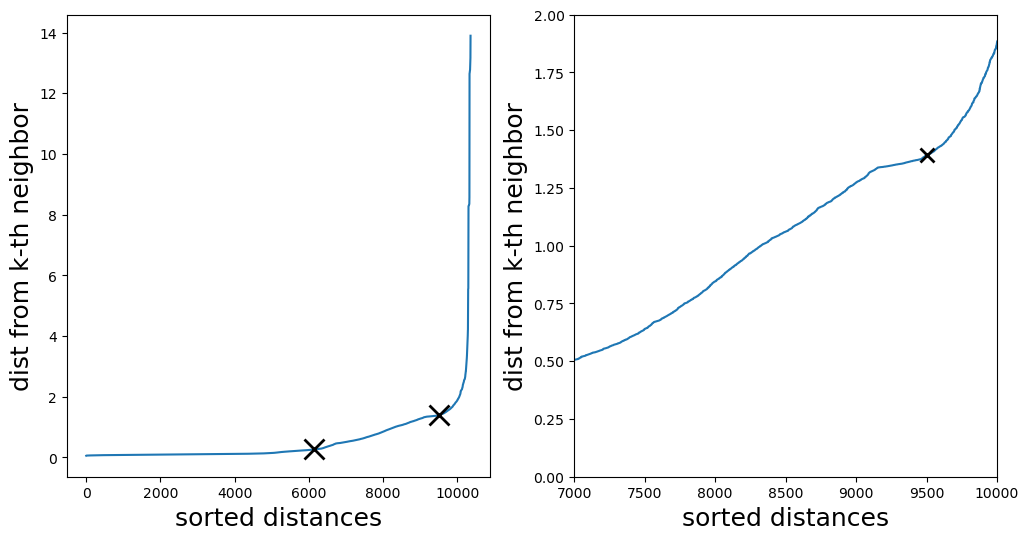

In [56]:
# troviamo il miglior valore di eps
fig,(ax,ax2)= plt.subplots(ncols=2,nrows=1,figsize=(12,6))

ax.plot(range(0, len(sorted_70)), sorted_70)
ax.set_ylabel('dist from k-th neighbor', fontsize=18)
ax.set_xlabel('sorted distances', fontsize=18)
ax.plot(9500,sorted_70[9500],marker="x",c="black",ms=15,mew=2)
ax.plot(6150,sorted_70[6150],marker="x",c="black",ms=15,mew=2)

ax2.plot(range(0, len(sorted_70)), sorted_70)
ax2.set_ylabel('dist from k-th neighbor', fontsize=18)
ax2.set_xlabel('sorted distances', fontsize=18)
ax2.set_ylim(0,2)
ax2.set_xlim(7000,10000)
ax2.plot(9500,sorted_70[9500],marker="x",c="black",ms=10,mew=2)

print("(min_points=70) -> EPS = "+ str(sorted_70[9500]))
print("(min_points=70) -> EPS = "+ str(sorted_70[6150]))

In [58]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import  silhouette_score
min_samples=70
eps= 1.3923116433716074
eps2=0.2596691289909367

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(cluster1)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))
print('eps= %s => K= %s, Silhouette %s' %(eps,clusters,silhouette_score(cluster1, dbscan.labels_)))

dbscan = DBSCAN(eps=eps2, min_samples=min_samples)
dbscan.fit(cluster1)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))
print('eps= %s => K= %s, Silhouette %s' %(eps2,clusters,silhouette_score(cluster1, dbscan.labels_)))

eps= 1.3923116433716074 => K= 2, Silhouette 0.5433566239224918
eps= 0.2596691289909367 => K= 4, Silhouette 0.13745087543927725


### Result: 
Il valore dello score è buono ma:<br>
1. K=2 implica che sia stato effettivamente individuato solo un cluster oltre quello di noise points, si procede allora per brute force
2. K=4 potrebbe essere buono ma lo score è troppo basso
Di seguiti si procede con un brute force in intervallo limitato

In [59]:
for eps_ in np.arange(0.1,2.1,0.1):    
    dbscan = DBSCAN(eps=eps_, min_samples=min_samples)
    dbscan.fit(cluster1)
    np.unique(dbscan.labels_, return_counts=True)
    clusters=len(np.unique(dbscan.labels_))
    print('eps= %s => K= %s, Silhouette %s' %(eps_,clusters,silhouette_score(cluster1, dbscan.labels_)))

eps= 0.1 => K= 2, Silhouette 0.2288750229465761
eps= 0.2 => K= 7, Silhouette 0.02501653906588698
eps= 0.30000000000000004 => K= 4, Silhouette 0.14826384210795104
eps= 0.4 => K= 4, Silhouette 0.19209723474736
eps= 0.5 => K= 5, Silhouette 0.3264975712740938
eps= 0.6 => K= 4, Silhouette 0.36422651590786853
eps= 0.7000000000000001 => K= 4, Silhouette 0.314379845821882
eps= 0.8 => K= 4, Silhouette 0.3173999990700769
eps= 0.9 => K= 6, Silhouette 0.2500469085869131
eps= 1.0 => K= 5, Silhouette 0.4223580124922869
eps= 1.1 => K= 4, Silhouette 0.493739174137806
eps= 1.2000000000000002 => K= 3, Silhouette 0.21921951558707894
eps= 1.3000000000000003 => K= 2, Silhouette 0.5187804115737327
eps= 1.4000000000000001 => K= 2, Silhouette 0.5472804831274785
eps= 1.5000000000000002 => K= 2, Silhouette 0.5715780808625776
eps= 1.6 => K= 2, Silhouette 0.5973013803923982
eps= 1.7000000000000002 => K= 2, Silhouette 0.6123016946349229
eps= 1.8000000000000003 => K= 2, Silhouette 0.6295033184430047
eps= 1.90000000

Ricordiamo che il DBscan considera come un cluster l'insieme dei noise data,per questa ragione anche se a partire da eps maggiore di 1.3 il silhouette score aumenta, in realtà staremmo solo dividendo tra noise value e non, avendo k=2.<br>
La soluzione sta nel condurre un ulteriore ricerce di eps nel range (1.0,1.2) dove sia k che lo score sono potenzialmente buoni.<br>

In [60]:
for eps_ in np.arange(1,1.21,0.01):    
    dbscan = DBSCAN(eps=eps_, min_samples=min_samples)
    dbscan.fit(cluster1)
    np.unique(dbscan.labels_, return_counts=True)
    clusters=len(np.unique(dbscan.labels_))
    print('eps= %s => K= %s, Silhouette %s' %(eps_,clusters,silhouette_score(cluster1, dbscan.labels_)))

eps= 1.0 => K= 5, Silhouette 0.4223580124922869
eps= 1.01 => K= 5, Silhouette 0.4228535520068763
eps= 1.02 => K= 5, Silhouette 0.4231736100774047
eps= 1.03 => K= 5, Silhouette 0.42488277974654376
eps= 1.04 => K= 5, Silhouette 0.4211593059014915
eps= 1.05 => K= 5, Silhouette 0.4210626817861232
eps= 1.06 => K= 5, Silhouette 0.4150943897476571
eps= 1.07 => K= 4, Silhouette 0.48390077383228136
eps= 1.08 => K= 4, Silhouette 0.48809075186064027
eps= 1.09 => K= 4, Silhouette 0.48951033751594447
eps= 1.1 => K= 4, Silhouette 0.493739174137806
eps= 1.11 => K= 4, Silhouette 0.49441974209121964
eps= 1.12 => K= 4, Silhouette 0.49566017396035283
eps= 1.1300000000000001 => K= 4, Silhouette 0.49579696521532385
eps= 1.1400000000000001 => K= 4, Silhouette 0.3031530183115946
eps= 1.1500000000000001 => K= 4, Silhouette 0.30478951715013114
eps= 1.1600000000000001 => K= 4, Silhouette 0.30543396222586794
eps= 1.1700000000000002 => K= 4, Silhouette 0.3049805217078914
eps= 1.1800000000000002 => K= 4, Silhouett

### E' importante notare che al variare di eps, k si mantiene abbastanza consistente, ciò avviene quando min_samples è adeguato al numero di features
Il miglior valore per **eps** sembra essere **1.13** <br>
eps= 1.13 => K= 4, Silhouette 0.49579696521532385

In [61]:
dbscan = DBSCAN(eps=1.13, min_samples=min_samples)
dbscan.fit(cluster1)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))
print('eps= %s => K= %s, Silhouette %s' %(1.13,clusters,silhouette_score(cluster1, dbscan.labels_)))

eps= 1.13 => K= 4, Silhouette 0.49579696521532385


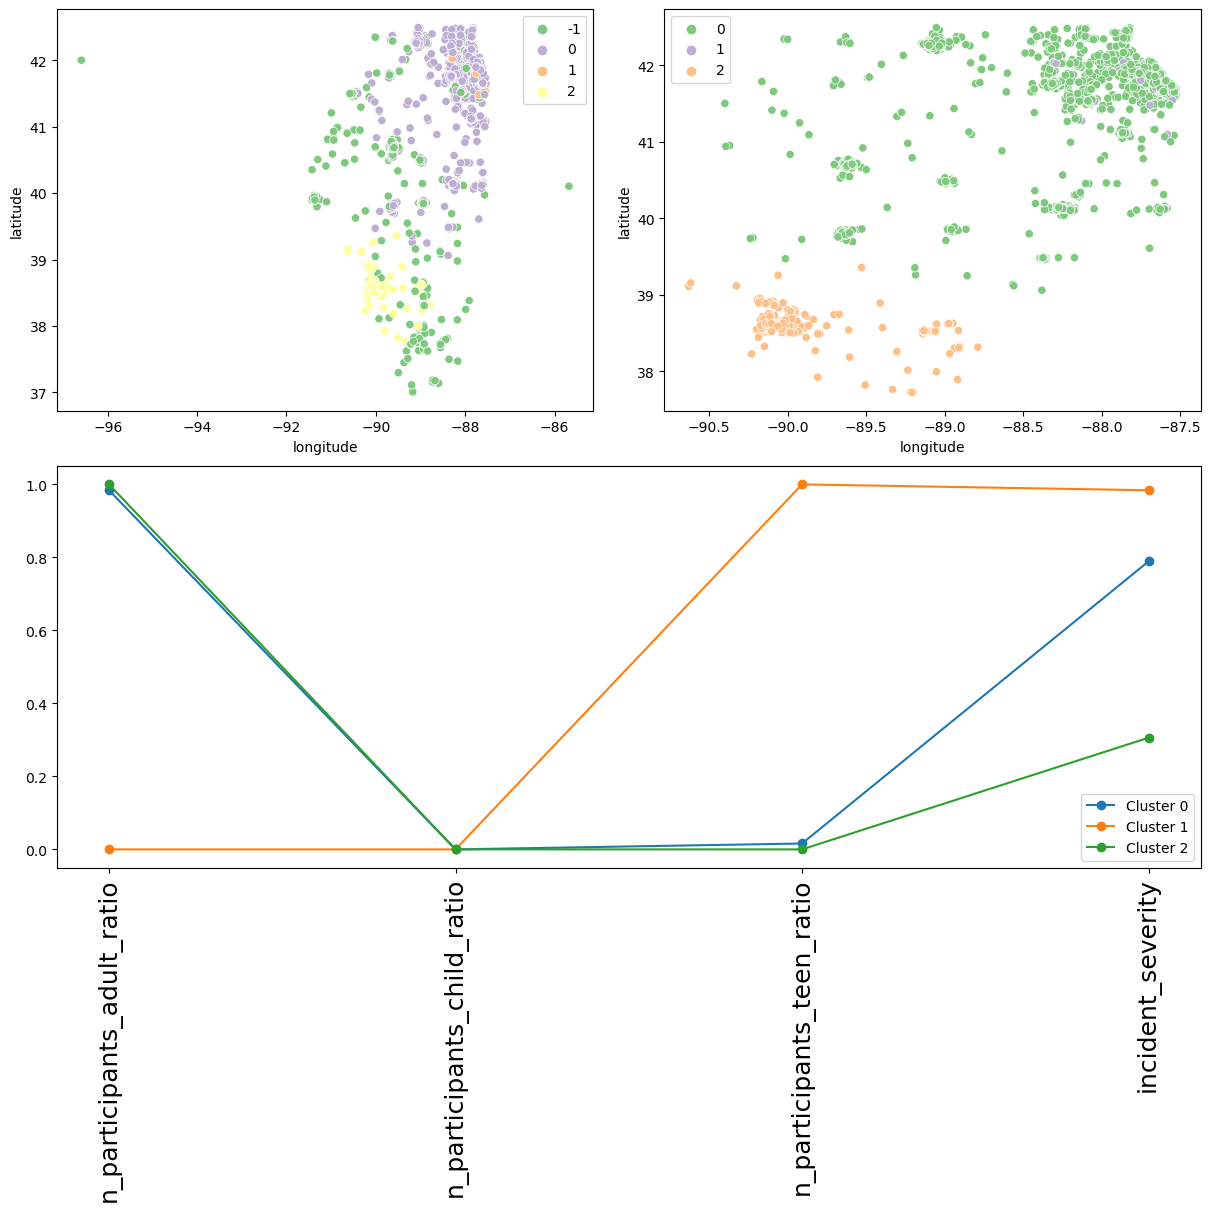

In [62]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
cluster1=old_data.copy()[["latitude","longitude","new_date", 'n_participants_adult_ratio','n_participants_child_ratio','n_participants_teen_ratio' ,'incident_severity']]

# do not forget constrained_layout=True to have some space between axes
fig = plt.figure(constrained_layout=True,figsize=(12,12))
gs = GridSpec(2, 2, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.scatterplot(x = "longitude", y = "latitude", data = cluster1, hue = dbscan.labels_, palette = "Accent", ax = ax)
#rimuovimo i noise points
cluster1["label"]=dbscan.labels_
temp = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1)[0])
cluster1=cluster1[cluster1["label"]>-1]
sns.scatterplot(x = "longitude", y = "latitude", data = cluster1, hue = temp, palette = "Accent", ax = ax2)
#rimuovimo i noise points
#droppiamo lat e long e new_date perchè non utili per la visualizzazione del prossimo grafico
cluster1=cluster1.drop(columns=["latitude","longitude","new_date"])
#calcoliamo la media dei valori degli attributi per i cluster
centers= []
centers.append(list(cluster1[cluster1["label"]==0].mean().drop("label")))
centers.append(list(cluster1[cluster1["label"]==1].mean().drop("label")))
centers.append(list(cluster1[cluster1["label"]==2].mean().drop("label")))
for i in range(0, len(centers)):
    ax3.plot(centers[i], marker='o', label='Cluster %s' % i)
ax3.set_xticks(range(0, len(cluster1.columns.drop("label"))), cluster1.columns.drop("label"), fontsize=18, rotation='vertical')
ax3.legend(fontsize=10)
plt.show()

## Clustering 2
Le operazione eseguite saranno le medesime quindi non sarà ripetuta la spiegazione

In [115]:
#metodo grafico per stimare EPS
dist = pdist(cluster2, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist
#la matrice risultante contiene alla posizione v_a,b la distanza euclidea tra il punto a e b.
sorted_70=getSortedList(70,dist)

(min_points=70) -> EPS = 1.772508748362806
(min_points=70) -> EPS = 0.3659824951044084


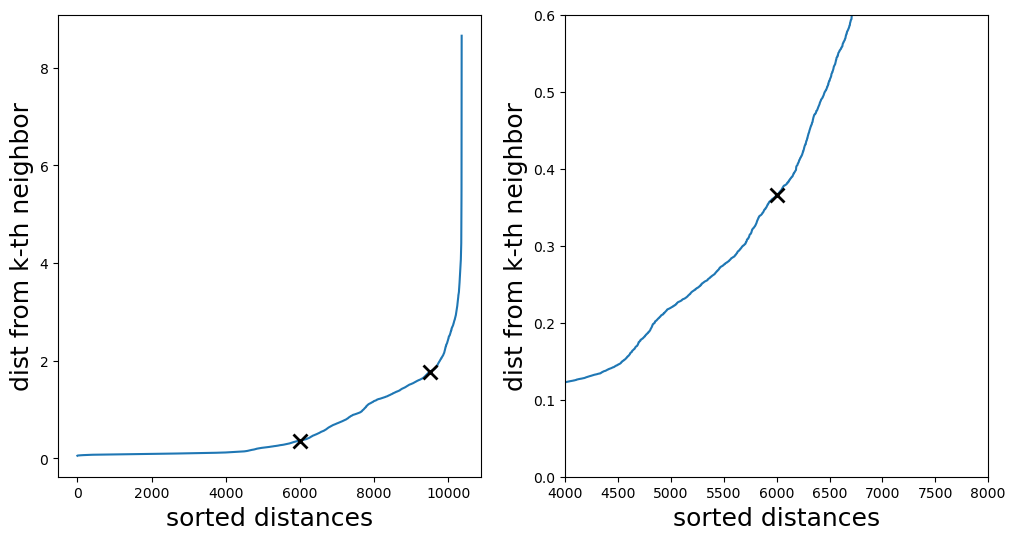

In [116]:
# troviamo il miglior valore di eps
fig,(ax,ax2)= plt.subplots(ncols=2,nrows=1,figsize=(12,6))

ax.plot(range(0, len(sorted_70)), sorted_70)
ax.set_ylabel('dist from k-th neighbor', fontsize=18)
ax.set_xlabel('sorted distances', fontsize=18)
ax.plot(6000,sorted_70[6000],marker="x",c="black",ms=10,mew=2)
ax.plot(9500,sorted_70[9500],marker="x",c="black",ms=10,mew=2)

ax2.plot(range(0, len(sorted_70)), sorted_70)
ax2.set_ylabel('dist from k-th neighbor', fontsize=18)
ax2.set_xlabel('sorted distances', fontsize=18)
ax2.set_ylim(0,0.6)
ax2.set_xlim(4000,8000)
ax2.plot(6000,sorted_70[6000],marker="x",c="black",ms=10,mew=2)
ax2.plot(9500,sorted_70[9500],marker="x",c="black",ms=10,mew=2)

print("(min_points=70) -> EPS = "+ str(sorted_70[9500]))
print("(min_points=70) -> EPS = "+ str(sorted_70[6000]))

In [117]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import  silhouette_score
min_samples=70
eps= 1.772508748362806
eps2=0.3659824951044084

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(cluster2)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))
print('eps= %s => K= %s, Silhouette %s' %(eps,clusters,silhouette_score(cluster2, dbscan.labels_)))

dbscan = DBSCAN(eps=eps2, min_samples=min_samples)
dbscan.fit(cluster2)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))
print('eps= %s => K= %s, Silhouette %s' %(eps2,clusters,silhouette_score(cluster2, dbscan.labels_)))

eps= 1.772508748362806 => K= 3, Silhouette 0.49618923563995665
eps= 0.3659824951044084 => K= 6, Silhouette 0.1270520843247921


### Result: 
Il valore degli score è buono per eps 1.77, si ricerca allora nell'intervallo [1,2.3]

In [ ]:
for eps_ in np.arange(1,2.35,0.05):    
    dbscan = DBSCAN(eps=eps_, min_samples=min_samples)
    dbscan.fit(cluster2)
    np.unique(dbscan.labels_, return_counts=True)
    clusters=len(np.unique(dbscan.labels_))
    print('eps= %s => K= %s, Silhouette %s' %(eps_,clusters,silhouette_score(cluster2, dbscan.labels_)))

Sembra che lo score aumenti mantenendo il numero di cluster (3 considerando noise data) all'aumentare di eps fino ad eps= 2.2, per eps maggiori si scende a due clusters e ciò non va bene.
Scegliamo allora eps = **2.2**

In [118]:
dbscan = DBSCAN(eps=2.2, min_samples=min_samples)
dbscan.fit(cluster2)
np.unique(dbscan.labels_, return_counts=True)
clusters=len(np.unique(dbscan.labels_))
print('eps= %s => K= %s, Silhouette %s' %(2.2,clusters,silhouette_score(cluster2, dbscan.labels_)))

eps= 2.2 => K= 3, Silhouette 0.5089644448950073


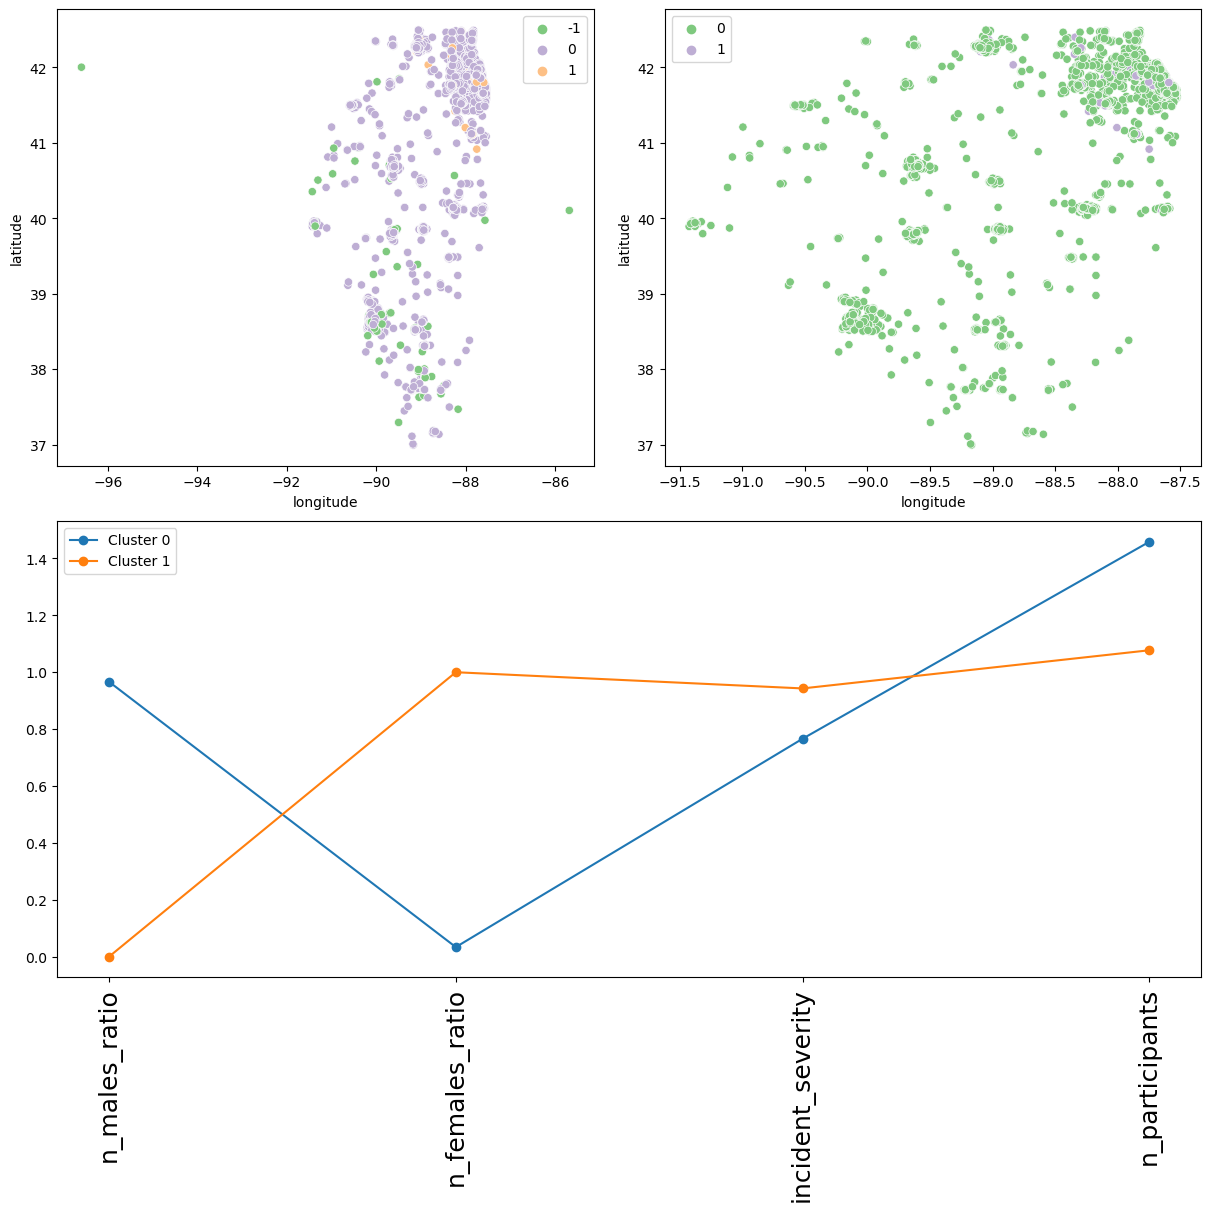

In [119]:
cluster2=old_data.copy()[["latitude","longitude","new_date", "n_males_ratio","n_females_ratio", 'incident_severity', 'n_participants']]
# do not forget constrained_layout=True to have some space between axes
fig = plt.figure(constrained_layout=True,figsize=(12,12))
gs = GridSpec(2, 2, figure=fig)
ax = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.scatterplot(x = "longitude", y = "latitude", data = cluster2, hue = dbscan.labels_, palette = "Accent", ax = ax)
#rimuovimo i noise points
cluster2["label"]=dbscan.labels_
temp = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1)[0])
cluster2=cluster2[cluster2["label"]>-1]
sns.scatterplot(x = "longitude", y = "latitude", data = cluster2, hue = temp, palette = "Accent", ax = ax2)
#rimuovimo i noise points
#droppiamo lat e long e new_date perchè non utili per la visualizzazione del prossimo grafico
cluster2=cluster2.drop(columns=["latitude","longitude","new_date"])
#calcoliamo la media dei valori degli attributi per i cluster
centers= []
centers.append(list(cluster2[cluster2["label"]==0].mean().drop("label")))
centers.append(list(cluster2[cluster2["label"]==1].mean().drop("label")))
for i in range(0, len(centers)):
    ax3.plot(centers[i], marker='o', label='Cluster %s' % i)
ax3.set_xticks(range(0, len(cluster2.columns.drop("label"))), cluster2.columns.drop("label"), fontsize=18, rotation='vertical')
ax3.legend(fontsize=10)
plt.show()

L'immagine di sotto è il risultato di DBSCAN con eps=1.55, il silhouette score è più basso ma questo clustering è più semplice da confrontare con quello ottenuto nella sezione **clustering 1** in quanto hanno lo stesso numero di cluster.<br>
Il clustering migliore risulta comunque essere quello plottato nella cella precedente in quanto rispecchia bene la descrizione della coppia (n_males_raio,n_females_ratio)

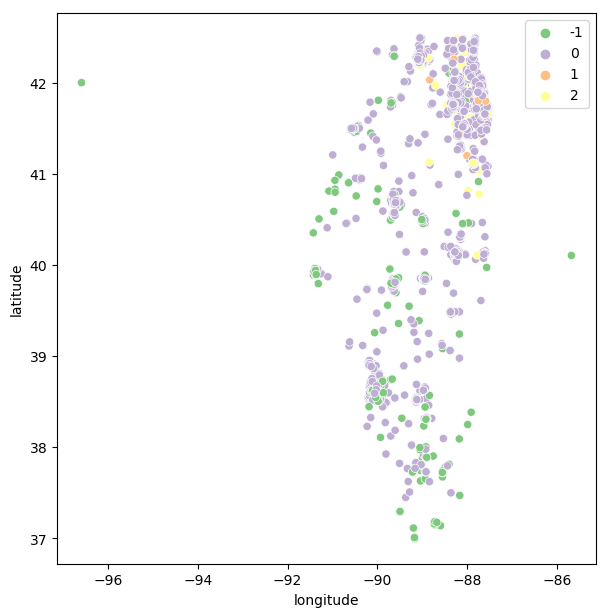